In [84]:
import os
import requests
import pandas as pd
import json
import numpy as np
import datetime as dt

In [111]:
# Calculo de Factor Geopolítico

# Recepción de datos
url_br1 = 'https://www.blackrock.com/blk-corp-assets/images/tools/blackrock-investment-institute/bgri-v2.json?770'
url_epu = 'https://www.policyuncertainty.com/media/All_Daily_Policy_Data.csv'

proxies = {}
response = requests.get(url=url_br1, proxies=proxies)
with open("br1.json","wb") as f:
    f.write(response.content)

with open("br1.json") as json_file:
    br1_df = pd.read_json(json_file)

proxies = {}
response = requests.get(url=url_epu, proxies=proxies)
with open("epu.csv","wb") as f:
    f.write(response.content)

with open("epu.csv") as csv_file:
    epu_df = pd.read_csv(csv_file)

# Organización de Datos
headers1 = ['date', 'COMP', 'CYBR', 'EMER', 'CHIN', 'TERR']

br1_df = br1_df.filter(headers1)

br1_df["date"] = pd.to_datetime(br1_df["date"])

br1_df = br1_df.set_index(['date'])

for i in list(br1_df.columns):
    br1_df[i + " Score"] = br1_df.apply(lambda row: 5 if row[i]<0 else(4 if row[i]<0.67 else(3 if row[i]<1.33 else(2 if row[i]<2 else 1))),axis=1)

epu_df["date"] = epu_df.apply(lambda row: dt.date(int(row['year']),int(row['month']),int(row['day'])),axis=1)
epu_df["date"] = pd.to_datetime(epu_df["date"])

epu_df = epu_df.set_index(['date'])

epu_df = epu_df.filter(['date','daily_policy_index'])

epu_df["mean_1264"] = epu_df.iloc[:,0].rolling(window = 1264).mean()
epu_df["std_1264"] = epu_df.iloc[:,0].rolling(window = 1264).std()
epu_df["mean_11"] = epu_df.iloc[:,0].rolling(window = 11).mean()
epu_df["norm"] = epu_df.apply(lambda row: None if row['mean_1264'] == None else abs((row['mean_11']-row['mean_1264'])/row['std_1264']),axis=1)

epu_df["EPU Score"] = epu_df.apply(lambda row: 5 if row['norm']<1 else(4 if row['norm']<2 else(3 if row['norm']<3 else(2 if row['norm']<4 else 1))),axis=1)

geopol_df = pd.merge(br1_df,epu_df,on='date')

geopol_df["Geopolítico"] = geopol_df.apply(lambda row: 0.2*row["COMP Score"]+0.15*row["CYBR Score"]+0.15*row["EMER Score"]+0.1*row["CHIN Score"]+0.1*row["TERR Score"]+0.3*row["EPU Score"],axis=1)

geopol_df = geopol_df.filter(['date','COMP Score','EMER Score','CHIN Score','TERR Score','EPU Score','Geopolítico'])

geopol_df

,COMP Score,EMER Score,CHIN Score,TERR Score,EPU Score,Geopolítico
date,,,,,,
2017-01-06,5,5,5,5,4,4.40
2017-01-13,5,4,5,5,4,4.25
2017-01-20,4,3,5,4,4,3.80
2017-01-27,4,3,5,4,4,3.80
2017-02-03,4,2,5,3,4,3.55
...,...,...,...,...,...,...
2021-05-21,5,4,4,5,5,4.75
2021-05-28,5,3,4,5,5,4.60
2021-06-04,5,3,4,5,5,4.60


In [113]:
# Calculo de Factor Económico

# Recepción de datos
url_br2 = 'https://www.blackrock.com/blk-corp-assets/images/tools/blackrock-investment-institute/macro-dash.json?477'

proxies = {}
response = requests.get(url=url_br2, proxies=proxies)
with open("br2.json","wb") as f:
    f.write(response.content)

with open("br2.json") as json_file:
    br2_df = pd.read_json(json_file,convert_dates=['i0'])

# Organización de Datos

# Fuente: https://www.blackrock.com/corporate/insights/blackrock-investment-institute/interactive-charts/macro-dashboard
# Inspect Element -> Sources -> top/www.blackrock.com/corporate/insights/blackrock-investment-institute-/interactive-charts/macro-dashboard/línea 740
headers3 = ['date', 'US Growth GPS', 'US Nowcast', 'US GDP Consensus', 'Germany Growth GPS', 'Germany Nowcast', 'Germany GDP Consensus',
'Japan Growth GPS', 'Japan Nowcast', 'Japan GDP Consensus', 'UK Growth GPS', 'UK Nowcast', 'UK GDP Consensus', 'France Growth GPS',
'France Nowcast', 'France GDP Consensus', 'Italy Growth GPS', 'Italy Nowcast', 'Italy GDP Consensus', 'Australia Growth GPS',
'Australia Nowcast', 'Australia GDP Consensus', 'Canada Growth GPS', 'Canada Nowcast', 'Canada GDP Consensus', 'G7 Growth GPS', 'G7 Nowcast',
'G7 GDP Consensus', 'China Growth GPS', 'China Nowcast', 'China PMI Consensus', 'Spain Growth GPS', 'Spain Nowcast',
'Spain GDP Consensus', 'EMU4 Growth GPS', 'EMU4 Nowcast', 'EMU4 GDP Consensus', 'US Inflation GPS', 'US Actual Inflation',
'US PCE Inflation GPS', 'US PCE Actual Inflation', 'EZ Inflation GPS', 'EZ Actual Inflation', 'UK Inflation GPS', 'UK Actual Inflation',
'CAN Inflation GPS', 'CAN Actual Inflation', 'JP Inflation GPS', 'JP Actual Inflation', 'SW Inflation GPS', 'SW Actual Inflation',
'US FCI', 'EZ FCI', 'JP FCI', 'G3 FCI', 'G3 GPS']

br2_df.columns = headers3

br2_df = br2_df.set_index(['date'])

headers4 = ['US Growth GPS','US FCI','G3 FCI','G3 GPS']

br2_df = br2_df.filter(headers4)

for i in list(br2_df.columns):
    br2_df[i + " Score"] = br2_df.apply(lambda row: 1 if row[i]<0 else(2 if row[i]<1.8 else(3 if row[i]<2.5 else(4 if row[i]<3 else 5))),axis=1)

br2_df["Económico"] = br2_df.apply(lambda row: 0.25*row["US Growth GPS Score"]+0.25*row["US FCI Score"]+0.25*row["G3 FCI Score"]+0.23*row["G3 GPS Score"],axis=1)

eco_df = br2_df

eco_df


,US Growth GPS,US FCI,G3 FCI,G3 GPS,US Growth GPS Score,US FCI Score,G3 FCI Score,G3 GPS Score,Económico
date,,,,,,,,,
2010-01-01,2.486,2.547,1.632,1.723,3,4,2,2,2.71
2010-01-08,2.514,2.418,1.634,1.790,4,3,2,2,2.71
2010-01-15,2.589,2.432,1.647,1.836,4,3,2,3,2.94
2010-01-22,2.576,2.406,1.614,1.826,4,3,2,3,2.94
2010-01-29,2.581,2.426,1.612,1.832,4,3,2,3,2.94
...,...,...,...,...,...,...,...,...,...
2021-07-02,4.469,3.803,2.834,3.916,5,5,4,5,4.65
2021-07-09,4.598,3.792,2.820,3.969,5,5,4,5,4.65
2021-07-16,4.404,3.803,2.827,3.864,5,5,4,5,4.65


<AxesSubplot:xlabel='date'>

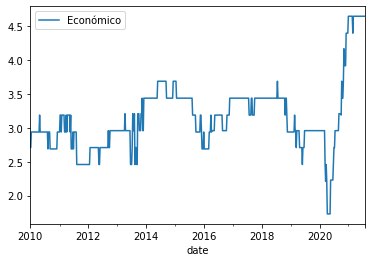

In [115]:
eco_df.filter(['Económico']).plot()

<AxesSubplot:xlabel='date'>

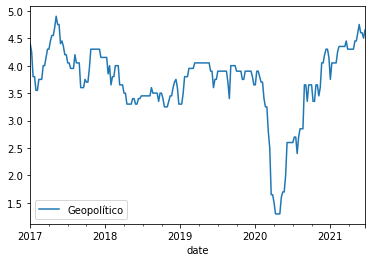

In [116]:
geopol_df.filter(['Geopolítico']).plot()